# Cohort 60x60 enlarged bootstraping AUCs analysis

### Imports and environment setup

- Date of run: 2024-09-26
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/sites/Scientific/Documentos compartidos/General/PHASE 6 - SOFTWARE DEVELOPMENT/DATA/../../../../../../:x:/s/Scientific/Eaw9d-fa2BREg_iZB1SL02YBG4mfVaJtoylG46bROmXVJA?e=8chcN7>)) was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [22]:
df_120 = pd.read_csv('../data/60x60_enlarged_20240926.csv' , sep='\t', index_col=0, header=0)


In [24]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [26]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL',
                    'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK',
                    'KPYM_MMK', 'PERM_MMK',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

In [27]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

In [28]:
BIOMARKERS = ['MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK', 'KPYM_MMK', 'PERM_MMK']

# Running the bootstrapping

We will do 1000 iterations of bootstraping and compare the mean of all predictions for al biomarkers (green dashed line) vs the AUC that the biomarker has by itself (red dashed line).

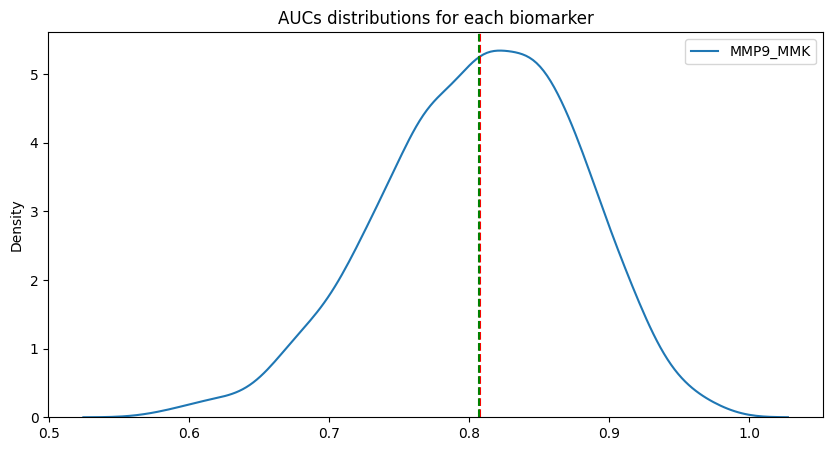

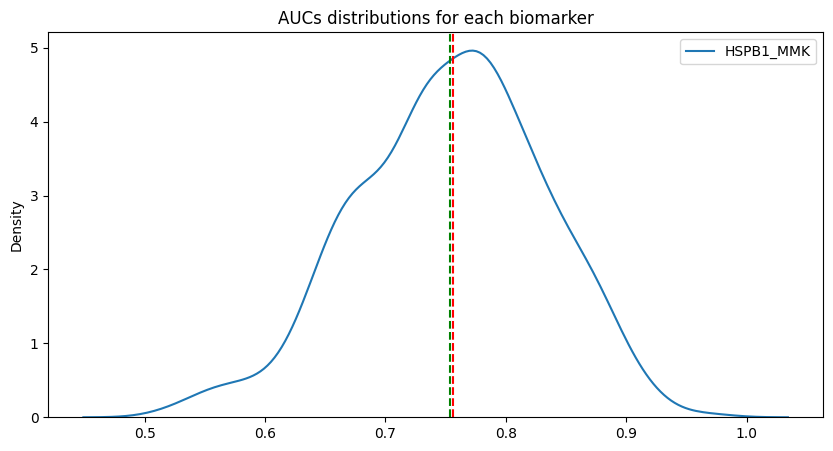

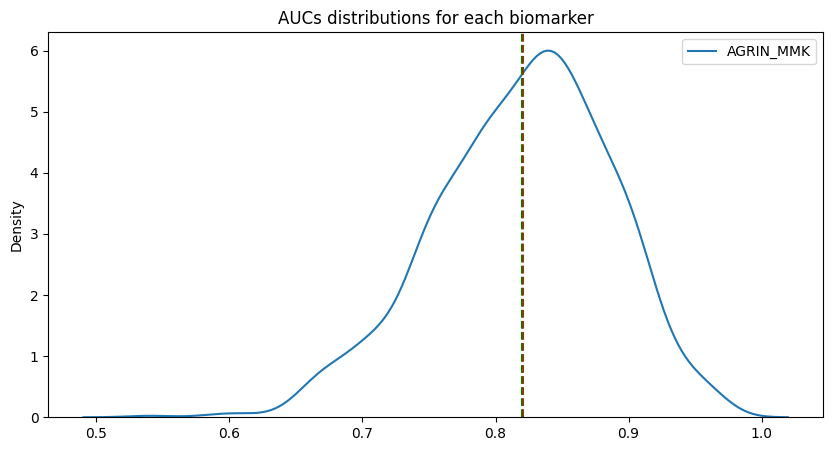

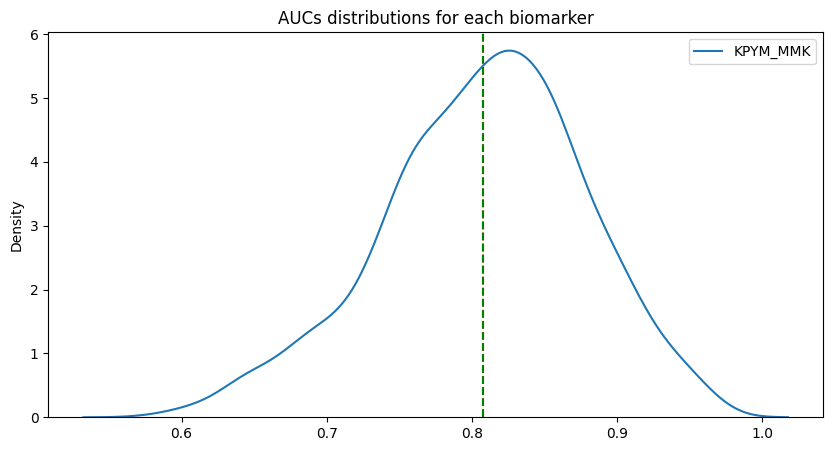

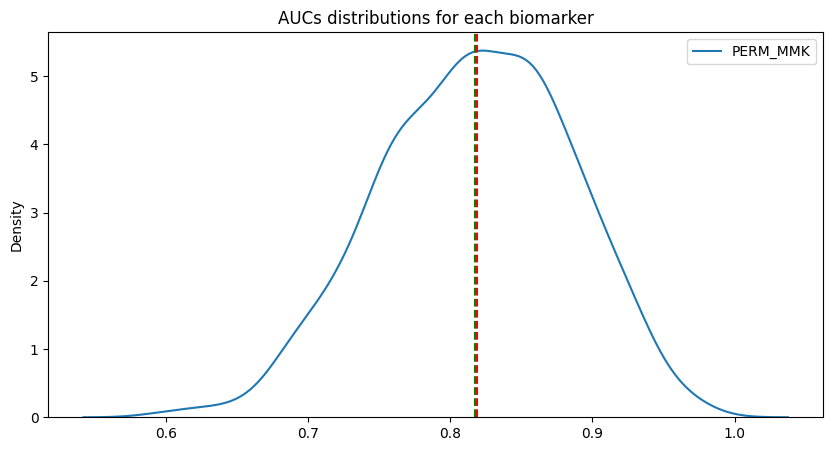

In [35]:
from sklearn.metrics import roc_auc_score

def bootstrap(df, n_samples=20):
    df_boot = df.sample(n=0, replace=True)
    for pathology in [0, 1]:
        df_path = df[df['Pathology'] == pathology]
        df_boot = pd.concat([df_boot, df_path.sample(n=n_samples, replace=True)])
    return df_boot

aucs = {}
for i in range(1000):
    df_boot = bootstrap(df_120)
    # Compute the AUC of the ROC curve for each biomarker
    for biomarker in BIOMARKERS:
        # compute the auc using stats lib
        df_boot_biomarker = df_boot.dropna(subset=[biomarker])
        auc = roc_auc_score(df_boot_biomarker['Pathology'], df_boot_biomarker[biomarker])
        # store the auc
        if biomarker not in aucs:
            aucs[biomarker] = []
        aucs[biomarker].append(auc)

# compute the AUCs on df_120 to compare
aucs_120 = {}
for biomarker in BIOMARKERS:
    # remove nans in interest columns
    df_120_biomarker = df_120.dropna(subset=[biomarker])
    auc = roc_auc_score(df_120_biomarker['Pathology'], df_120_biomarker[biomarker])
    aucs_120[biomarker] = auc

# Plot the AUCs distributions
for biomarker in BIOMARKERS:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.kdeplot(aucs[biomarker], label=biomarker)
    plt.axvline(aucs_120[biomarker], color='r', linestyle='--')
    plt.axvline(np.mean(aucs[biomarker]), color='g', linestyle='--')
    plt.legend()
    plt.title('AUCs distributions for each biomarker')
    plt.show()


As expected, the differences between both are almost none: sampling sometimes improves the prediction and other times it's worst, but, in mean, they compensate and are the same, except for an epsilon based on randomness.